Check effect of Negative Voja learning rule on MEG response

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

import h5py

# Full Vocab

In [2]:
n_items = 16
dimensions = 32
n_neurons = 500

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [3]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

n_repeats = 5
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_pause = t_pause/dt

intercepts = [0.2]*n_neurons

In [4]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

Building finished in 0:00:01.                                                   


In [5]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    neg_voja = NegVoja(enc.copy(), learning_rate=(5e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(paused, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:58.                                                 


In [6]:
fin_enc = neg_voja.encoder_hist[-1].copy()

## Verification

In [7]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [8]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [9]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [10]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

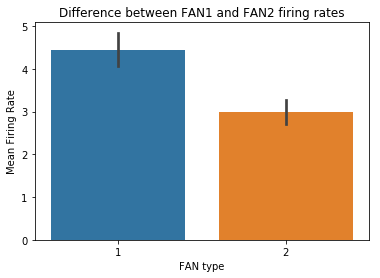

In [11]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

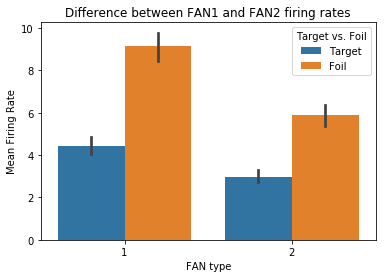

In [12]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

## Selectively weaken inhibition for targets

So the foils don't have such a big MEG response

### Train recurrent connections

In [13]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [49]:
n_repeats = 6

t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

In [50]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)
    rec_learn = rec_bcm.RecBCM(n_neurons, rec_inhib, learning_rate=5e-7, threshold=150, max_inhib=-0.05, sample_every=t_each/2)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, rec_learn.in_neurons, synapse=0.01)
    nengo.Connection(ens.neurons, rec_learn.out_neurons, synapse=0.01)
    nengo.Connection(paused, rec_learn.enable, synapse=None)
    nengo.Connection(rec_learn.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:09:50.                                                 


In [52]:
lowpass = nengo.Lowpass(0.1)
nrn_rates = lowpass.filt(sim.data[p_spikes])

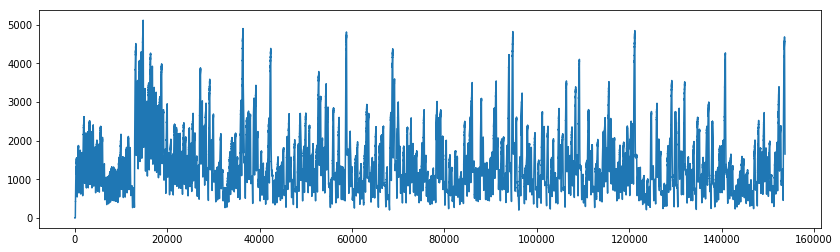

In [53]:
plt.figure(figsize=(14, 4))
plt.plot(np.sum(nrn_rates, axis=1))

### Weight analysis

In [54]:
w_hist = np.array(rec_learn.weight_history)

In [55]:
w_hist.shape

(793, 500, 500)

In [56]:
triu_i  = np.triu_indices(w_hist.shape[1], k=1)
tril_i = np.tril_indices(w_hist.shape[1], k=-1)
wh_arr = np.concatenate((w_hist[:,  triu_i[0], triu_i[1]], w_hist[:, tril_i[0], tril_i[1]]), axis=1)

In [57]:
wh_arr.shape

(793, 249500)

In [58]:
wh_diff = np.diff(wh_arr, axis=0)
print(wh_diff.shape)
print(wh_diff.shape[0] * wh_diff.shape[1])

(792, 249500)
197604000


In [86]:
decr = wh_arr[-1][wh_arr[-1] < -1e-5].shape[0]
print("Number of weights decreased by the end", decr)
incr = wh_arr[-1][wh_arr[-1] > -1e-5].shape[0]
print("Number of weights increased by the end", incr)
print("Total changed", decr+incr)

Number of weights decreased by the end 110459
Number of weights increased by the end 8849
Total changed 119308


In [113]:
thresh = -1e-3

min_w = wh_arr[-1][wh_arr[-1] < -1e-3].shape[0]
print(f"Number of weights decreased beyond {thresh}: {min_w}" )

Number of weights decreased beyond -0.001: 6559


In [59]:
print("Weights that actually changed")
wh_diff.shape[0] * wh_diff.shape[1] - wh_diff[wh_diff == 0].shape[0]

Weights that actually changed


2079941

In [95]:
wobble = np.sum(np.abs(wh_diff), axis=0)

In [97]:
wob_idx = np.argsort(wobble)

In [106]:
min_wob = wh_diff[:, wob_idx[:10]]
max_wob = wh_diff[:, wob_idx[-10:]]

In [110]:
wobble[wobble <= 0.0001].shape

(193720,)

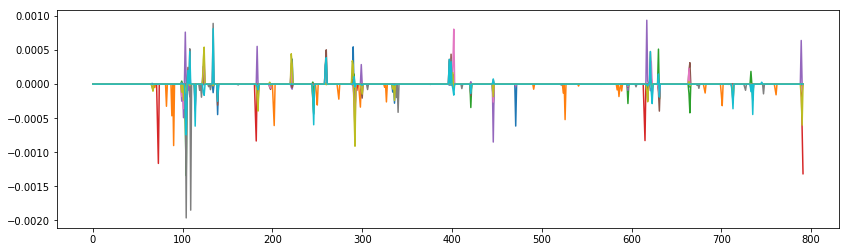

In [111]:
plt.figure(figsize=(14, 4))
plt.plot(max_wob);

### Save Results

In [115]:
import h5py

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [120]:
with h5py.File("../data/neg_voja_rec_learn_long.h5", "w") as fi:
    #fi.create_dataset("spikes", sim.data[p_spikes])
    fi.create_dataset("rec_weights", data=w_hist)

### Evaluate recurrent connections on foils

In [60]:
rec_w = rec_learn.weight_history[-1].copy()

In [61]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [62]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as learned_model:
    in_nd = nengo.Node(feed.feed)
    
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


In [63]:
learned_spikes = learned_sim.data[p_spikes].copy()

In [64]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

with nengo.Network() as base_model:
    in_nd = nengo.Node(feed.feed)
    
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:15.                                                 


In [65]:
base_spikes = base_sim.data[p_spikes].copy()

In [66]:
base_meg = meg_from_spikes(base_spikes)
learned_meg = meg_from_spikes(learned_spikes)

In [67]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

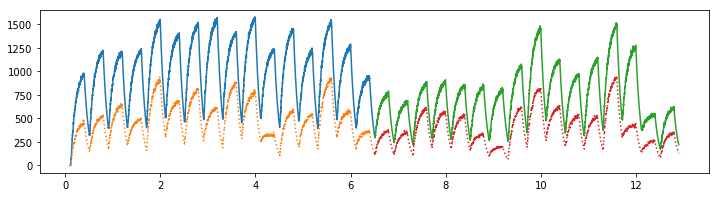

In [68]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], base_meg[fan1_slc])
plt.plot(sim.trange()[fan1_slc], learned_meg[fan1_slc], linestyle=":")
plt.plot(sim.trange()[fan2_slc], base_meg[fan2_slc])
plt.plot(sim.trange()[fan2_slc], learned_meg[fan2_slc], linestyle=":")

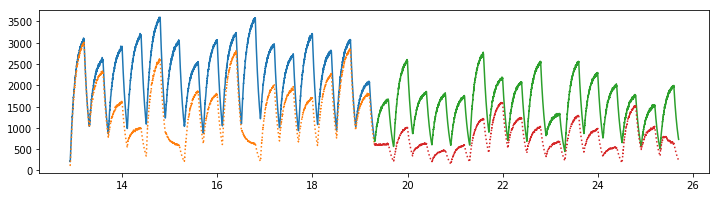

In [69]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[foil1_slc], base_meg[foil1_slc])
plt.plot(sim.trange()[foil1_slc], learned_meg[foil1_slc], linestyle=":")
plt.plot(sim.trange()[foil2_slc], base_meg[foil2_slc])
plt.plot(sim.trange()[foil2_slc], learned_meg[foil2_slc], linestyle=":")

In [70]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [71]:
df_list = []

for key, obj in slc_stim_vecs.items():
    meg_diff = base_meg[obj.slc] - learned_meg[obj.slc]
    resp = [obj.fan_num] * len(meg_diff)
    targ = [obj.targ] * len(meg_diff)
    df_list.append(pd.DataFrame({"diff": meg_diff, "resp": resp, "targ": targ}))

meg_diff_df = pd.concat(df_list)

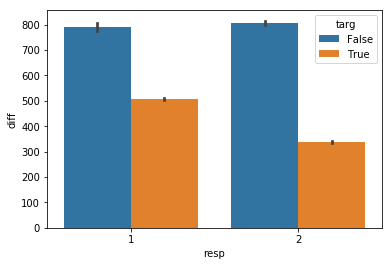

In [72]:
ax = sns.barplot(x="resp", y="diff", hue="targ", data=meg_diff_df)

In [73]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = learned_meg[obj.slc]
    resp = [obj.fan_num] * len(meg_diff)
    targ = [obj.targ] * len(meg_diff)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

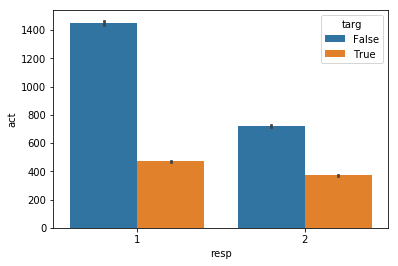

In [74]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)